# Partial Correlation Analysis: Testing Dorsal Independence

Analysis of pIPS connectivity after regressing out ventral (LO) influence.

**Research Question**: Is dorsal pathway connectivity during object viewing independent of ventral pathway activity, or does it represent passive spillover?

**Approach**: Compare original pIPS FC maps with 'cleaned' pIPS FC maps (ventral variance removed)

In [8]:
# Import libraries
import os
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
import seaborn as sns
from nilearn import image, plotting, datasets
from nilearn.input_data import NiftiMasker
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


/home/csimmon2/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [9]:
# Set up paths
study_dir = "/lab_data/behrmannlab/vlad/ptoc"  # For original FC maps
residual_dir = "/user_data/csimmon2/ptoc_residuals"  # For cleaned FC maps
results_dir = "/user_data/csimmon2/git_repos/ptoc/results"
curr_dir = "/user_data/csimmon2/git_repos/ptoc"

# Load subject info
sub_info = pd.read_csv(f'{curr_dir}/sub_info.csv')
subjects = sub_info[sub_info['group'] == 'control']['sub'].tolist()

print(f"Found {len(subjects)} control subjects")
print(f"Original data path: {study_dir}")
print(f"Residual data path: {residual_dir}")
print(f"Subjects: {subjects[:5]}...")  # Show first 5

Found 19 control subjects
Original data path: /lab_data/behrmannlab/vlad/ptoc
Residual data path: /user_data/csimmon2/ptoc_residuals
Subjects: ['sub-025', 'sub-038', 'sub-057', 'sub-059', 'sub-064']...


## Helper Functions

In [12]:
def load_fc_maps(subjects, analysis_type, roi, hemisphere, task='loc'):
    """Load FC maps for all subjects"""
    maps = []
    valid_subjects = []
    
    for sub in subjects:
        if analysis_type == 'original':
            # Original maps are in the main study directory
            filepath = f"{study_dir}/{sub}/ses-01/derivatives/fc_mni/{sub}_{roi}_{hemisphere}_{task}_fc_mni.nii.gz"
        elif analysis_type == 'cleaned':
            # Cleaned maps are in the residual directory
            filepath = f"{residual_dir}/{sub}/ses-01/derivatives/fc_mni/{sub}_pIPS_clean_{hemisphere}_{task}_fc_mni.nii.gz"
        
        if os.path.exists(filepath):
            maps.append(filepath)
            valid_subjects.append(sub)
        else:
            print(f"Missing: {os.path.basename(filepath)} for {sub}")
    
    roi_name = roi if analysis_type == 'original' else 'pIPS_clean'
    print(f"Found {len(maps)} {analysis_type} {roi_name} {hemisphere} maps")
    return maps, valid_subjects

def compute_group_stats(maps, mask=None):
    """Compute group-level statistics"""
    if not maps:
        return None, None
        
    # Load all maps
    imgs = [nib.load(map_path) for map_path in maps]
    
    # Compute group mean
    group_img = image.mean_img(imgs)
    
    # Compute one-sample t-test if mask provided
    if mask is not None:
        masker = NiftiMasker(mask_img=mask)
        data = masker.fit_transform(imgs)
        t_stats, p_vals = stats.ttest_1samp(data, 0, axis=0)
        t_img = masker.inverse_transform(t_stats)
        return group_img, t_img
    else:
        return group_img, None

def compute_dice_coefficient(img1, img2, threshold=2.3):
    """Compute Dice coefficient between two statistical maps"""
    # Threshold images
    mask1 = image.math_img(f'img > {threshold}', img=img1)
    mask2 = image.math_img(f'img > {threshold}', img=img2)
    
    # Get binary arrays
    data1 = mask1.get_fdata().flatten()
    data2 = mask2.get_fdata().flatten()
    
    # Remove NaN values
    valid = ~(np.isnan(data1) | np.isnan(data2))
    data1, data2 = data1[valid], data2[valid]
    
    # Compute Dice coefficient
    intersection = np.sum(data1 * data2)
    total = np.sum(data1) + np.sum(data2)
    dice = (2 * intersection) / total if total > 0 else 0
    
    return dice

print("Helper functions defined!")

Helper functions defined!


## Load FC Maps

**Note: Make sure your MNI transformation completed successfully before running this section!**

In [13]:
print("Loading FC maps...")

# Quick verification - check if directories exist
print("\nVerifying data directories:")
for sub in subjects[:3]:  # Check first 3 subjects
    orig_dir = f"{study_dir}/{sub}/ses-01/derivatives/fc_mni"
    resid_dir = f"{residual_dir}/{sub}/ses-01/derivatives/fc_mni"
    
    print(f"\n{sub}:")
    print(f"  Original dir exists: {os.path.exists(orig_dir)}")
    print(f"  Residual dir exists: {os.path.exists(resid_dir)}")
    
    if os.path.exists(resid_dir):
        resid_files = [f for f in os.listdir(resid_dir) if f.endswith('.nii.gz')]
        print(f"  Residual files: {len(resid_files)} files")
        if resid_files:
            print(f"    Examples: {resid_files[:2]}")

Loading FC maps...

Verifying data directories:

sub-025:
  Original dir exists: True
  Residual dir exists: True
  Residual files: 2 files
    Examples: ['sub-025_pIPS_clean_right_loc_fc_mni.nii.gz', 'sub-025_pIPS_clean_left_loc_fc_mni.nii.gz']

sub-038:
  Original dir exists: True
  Residual dir exists: True
  Residual files: 2 files
    Examples: ['sub-038_pIPS_clean_left_loc_fc_mni.nii.gz', 'sub-038_pIPS_clean_right_loc_fc_mni.nii.gz']

sub-057:
  Original dir exists: True
  Residual dir exists: True
  Residual files: 2 files
    Examples: ['sub-057_pIPS_clean_left_loc_fc_mni.nii.gz', 'sub-057_pIPS_clean_right_loc_fc_mni.nii.gz']


In [14]:
print("\n" + "="*50)
print("Loading all maps...")

# Load original pIPS maps
pips_orig_left, subs_pips_orig_left = load_fc_maps(subjects, 'original', 'pIPS', 'left')
pips_orig_right, subs_pips_orig_right = load_fc_maps(subjects, 'original', 'pIPS', 'right')

# Load cleaned pIPS maps  
pips_clean_left, subs_pips_clean_left = load_fc_maps(subjects, 'cleaned', 'pIPS', 'left')
pips_clean_right, subs_pips_clean_right = load_fc_maps(subjects, 'cleaned', 'pIPS', 'right')

# Load LO maps for comparison
lo_orig_left, subs_lo_left = load_fc_maps(subjects, 'original', 'LO', 'left')
lo_orig_right, subs_lo_right = load_fc_maps(subjects, 'original', 'LO', 'right')

print("\nData loading complete!")


Loading all maps...
Found 19 original pIPS left maps
Found 19 original pIPS right maps
Missing: sub-084_pIPS_clean_left_loc_fc_mni.nii.gz for sub-084
Found 18 cleaned pIPS_clean left maps
Missing: sub-084_pIPS_clean_right_loc_fc_mni.nii.gz for sub-084
Found 18 cleaned pIPS_clean right maps
Found 19 original LO left maps
Found 19 original LO right maps

Data loading complete!


## Compute Group Statistics

In [15]:
print("Computing group statistics...")

# Get MNI brain mask
mni_mask = datasets.load_mni152_brain_mask()

# Original pIPS
pips_orig_left_mean, pips_orig_left_t = compute_group_stats(pips_orig_left, mni_mask)
pips_orig_right_mean, pips_orig_right_t = compute_group_stats(pips_orig_right, mni_mask)

# Cleaned pIPS
pips_clean_left_mean, pips_clean_left_t = compute_group_stats(pips_clean_left, mni_mask)
pips_clean_right_mean, pips_clean_right_t = compute_group_stats(pips_clean_right, mni_mask)

# LO for comparison
lo_left_mean, lo_left_t = compute_group_stats(lo_orig_left, mni_mask)
lo_right_mean, lo_right_t = compute_group_stats(lo_orig_right, mni_mask)

print("Group statistics computed!")

Computing group statistics...
Group statistics computed!


## Compute Difference Maps

In [16]:
print("Computing difference maps...")

# Difference: Original - Cleaned (what was removed)
diff_left = None
diff_right = None

if pips_orig_left_mean and pips_clean_left_mean:
    diff_left = image.math_img('img1 - img2', 
                               img1=pips_orig_left_mean, 
                               img2=pips_clean_left_mean)
    print("Left hemisphere difference map computed")

if pips_orig_right_mean and pips_clean_right_mean:
    diff_right = image.math_img('img1 - img2', 
                                img1=pips_orig_right_mean, 
                                img2=pips_clean_right_mean)
    print("Right hemisphere difference map computed")

Computing difference maps...
Left hemisphere difference map computed
Right hemisphere difference map computed


## Visualization

Creating visualizations...
Visualization saved to: /user_data/csimmon2/git_repos/ptoc/results/partial_correlation_analysis.png


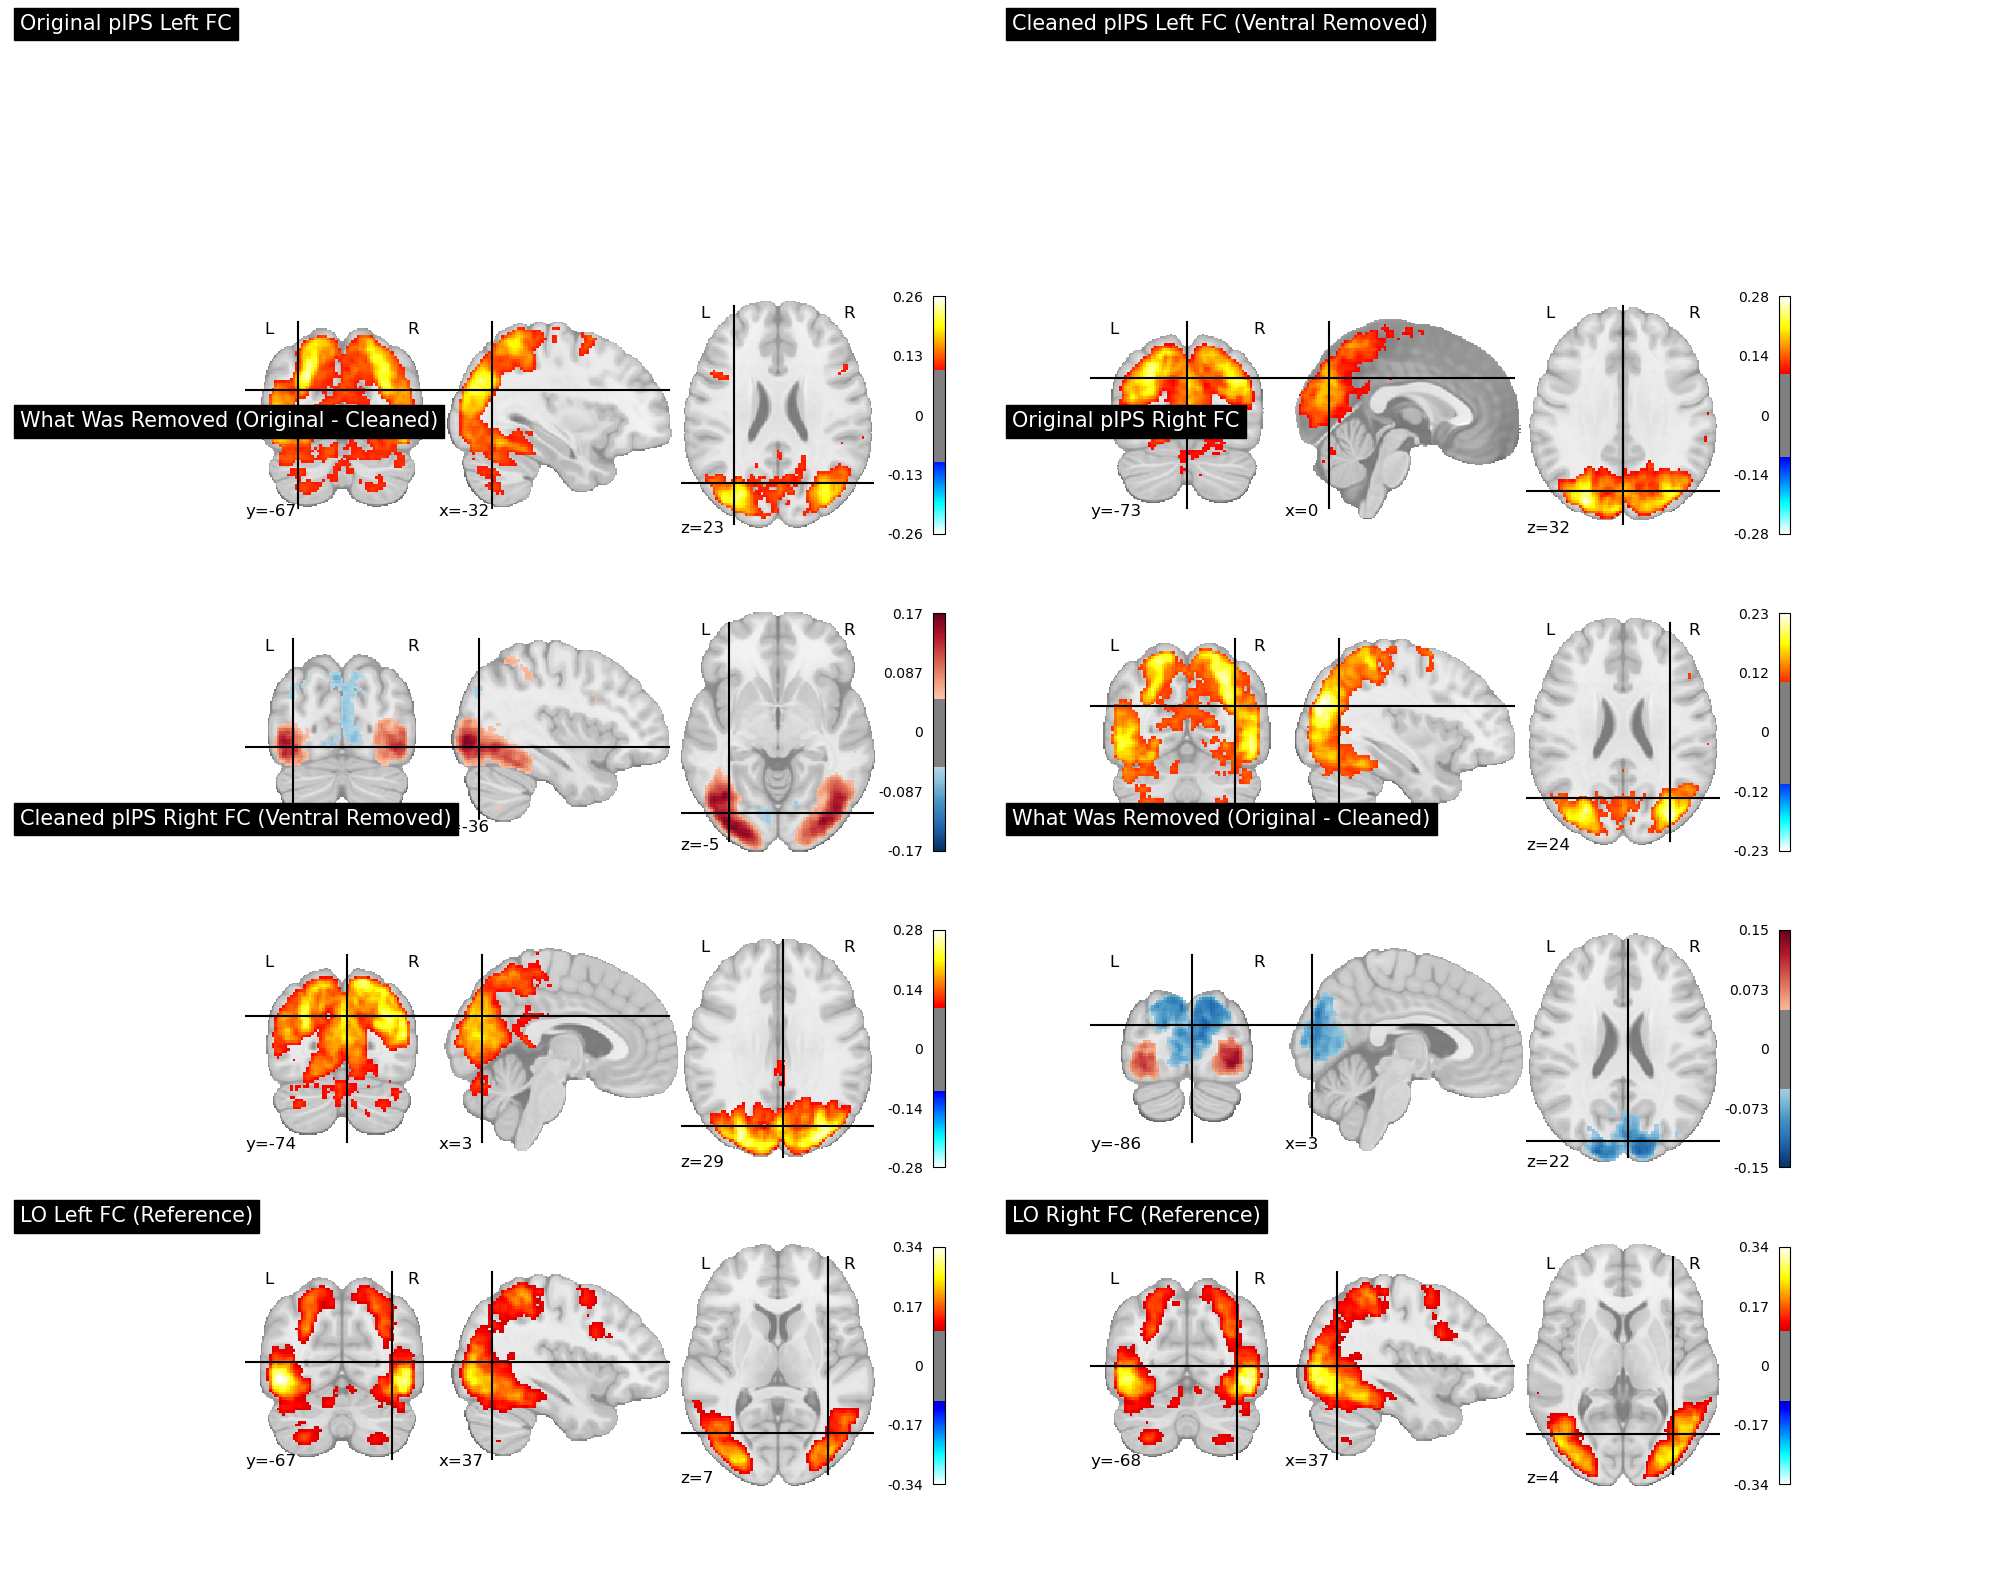

Visualization complete!


In [17]:
print("Creating visualizations...")

# Set up figure
fig = plt.figure(figsize=(20, 24))

# Left Hemisphere Analysis
if pips_orig_left_mean and pips_clean_left_mean:
    # Original pIPS Left
    ax1 = plt.subplot(6, 2, 1)
    plotting.plot_stat_map(pips_orig_left_mean, 
                          title='Original pIPS Left FC',
                          threshold=0.1,
                          axes=ax1,
                          colorbar=True)
    
    # Cleaned pIPS Left  
    ax2 = plt.subplot(6, 2, 2)
    plotting.plot_stat_map(pips_clean_left_mean,
                          title='Cleaned pIPS Left FC (Ventral Removed)', 
                          threshold=0.1,
                          axes=ax2,
                          colorbar=True)
    
    # Difference Left
    if diff_left:
        ax3 = plt.subplot(6, 2, 3)
        plotting.plot_stat_map(diff_left,
                              title='What Was Removed (Original - Cleaned)',
                              threshold=0.05,
                              axes=ax3,
                              colorbar=True,
                              cmap='RdBu_r')

# Right Hemisphere Analysis  
if pips_orig_right_mean and pips_clean_right_mean:
    # Original pIPS Right
    ax4 = plt.subplot(6, 2, 4)
    plotting.plot_stat_map(pips_orig_right_mean,
                          title='Original pIPS Right FC',
                          threshold=0.1,
                          axes=ax4,
                          colorbar=True)
    
    # Cleaned pIPS Right
    ax5 = plt.subplot(6, 2, 5)  
    plotting.plot_stat_map(pips_clean_right_mean,
                          title='Cleaned pIPS Right FC (Ventral Removed)',
                          threshold=0.1,
                          axes=ax5,
                          colorbar=True)
    
    # Difference Right
    if diff_right:
        ax6 = plt.subplot(6, 2, 6)
        plotting.plot_stat_map(diff_right,
                              title='What Was Removed (Original - Cleaned)', 
                              threshold=0.05,
                              axes=ax6,
                              colorbar=True,
                              cmap='RdBu_r')

# LO Reference Maps
if lo_left_mean:
    ax7 = plt.subplot(6, 2, 7)
    plotting.plot_stat_map(lo_left_mean,
                          title='LO Left FC (Reference)',
                          threshold=0.1,
                          axes=ax7,
                          colorbar=True)

if lo_right_mean:
    ax8 = plt.subplot(6, 2, 8)
    plotting.plot_stat_map(lo_right_mean,
                          title='LO Right FC (Reference)',
                          threshold=0.1,
                          axes=ax8,
                          colorbar=True)

plt.tight_layout()
plt.savefig(f'{results_dir}/partial_correlation_analysis.png', dpi=300, bbox_inches='tight')
print(f"Visualization saved to: {results_dir}/partial_correlation_analysis.png")
plt.show()

print("Visualization complete!")

## Quantitative Analysis

In [18]:
print("\n" + "="*50)
print("QUANTITATIVE ANALYSIS")
print("="*50)

# Compute overlap metrics
results_df = pd.DataFrame()

hemispheres = ['left', 'right']
for hemi in hemispheres:
    if hemi == 'left':
        orig_mean = pips_orig_left_mean
        clean_mean = pips_clean_left_mean  
        lo_mean = lo_left_mean
        orig_t = pips_orig_left_t
        clean_t = pips_clean_left_t
    else:
        orig_mean = pips_orig_right_mean
        clean_mean = pips_clean_right_mean
        lo_mean = lo_right_mean
        orig_t = pips_orig_right_t
        clean_t = pips_clean_right_t
    
    if orig_mean and clean_mean and lo_mean:
        # Dice coefficients
        dice_orig_lo = compute_dice_coefficient(orig_mean, lo_mean)
        dice_clean_lo = compute_dice_coefficient(clean_mean, lo_mean)
        dice_orig_clean = compute_dice_coefficient(orig_mean, clean_mean)
        
        # Count significant voxels (if t-stats available)
        if orig_t and clean_t:
            orig_sig_voxels = np.sum(np.abs(orig_t.get_fdata()) > 2.3)
            clean_sig_voxels = np.sum(np.abs(clean_t.get_fdata()) > 2.3)
            percent_retained = (clean_sig_voxels / orig_sig_voxels) * 100 if orig_sig_voxels > 0 else 0
        else:
            orig_sig_voxels = clean_sig_voxels = percent_retained = np.nan
        
        # Store results
        results_df = pd.concat([results_df, pd.DataFrame({
            'hemisphere': [hemi],
            'dice_original_LO': [dice_orig_lo],
            'dice_cleaned_LO': [dice_clean_lo], 
            'dice_original_cleaned': [dice_orig_clean],
            'orig_sig_voxels': [orig_sig_voxels],
            'clean_sig_voxels': [clean_sig_voxels],
            'percent_connectivity_retained': [percent_retained]
        })], ignore_index=True)

# Display results
print("\nOVERLAP ANALYSIS:")
print(results_df.round(3))


QUANTITATIVE ANALYSIS



OVERLAP ANALYSIS:
  hemisphere  dice_original_LO  dice_cleaned_LO  dice_original_cleaned  \
0       left                 0                0                      0   
1      right                 0                0                      0   

   orig_sig_voxels  clean_sig_voxels  percent_connectivity_retained  
0          1501005           1163689                         77.527  
1          1567595           1322715                         84.379  


## Save Results

In [ ]:
# Save quantitative results
os.makedirs(results_dir, exist_ok=True)
results_df.to_csv(f'{results_dir}/partial_correlation_metrics.csv', index=False)
print(f"📊 Results saved to: {results_dir}/partial_correlation_metrics.csv")
print(f"🖼️  Visualization saved to: {results_dir}/partial_correlation_analysis.png")

## Summary

### Key Questions to Ask:

**1. CONNECTIVITY RETENTION:**
- **>70% retained** → Strong evidence for dorsal independence
- **30-70% retained** → Moderate independence with some ventral dependence  
- **<30% retained** → Suggests significant ventral dependence

**2. OVERLAP REDUCTION:**
- **Large reduction** in pIPS-LO overlap → Successful removal of shared variance
- **Small reduction** → Limited shared variance to begin with

**3. SPATIAL PATTERNS:**
- Check difference maps: What regions show largest changes?
- Are remaining connections in expected dorsal areas?
- Do cleaned maps still show object-selective patterns?

### Next Steps:
- Compare with your existing PPI results
- Consider running group-level statistics on cleaned maps
- Examine specific ROI-to-ROI connectivity changes

In [19]:
print("\n" + "="*50) 
print("ANALYSIS COMPLETE!")
print("="*50)
print("Review the visualizations and metrics above to determine dorsal pathway independence.")
print("\nKey files generated:")
print(f"- Visualization: {results_dir}/partial_correlation_analysis.png")
print(f"- Metrics: {results_dir}/partial_correlation_metrics.csv")


ANALYSIS COMPLETE!
Review the visualizations and metrics above to determine dorsal pathway independence.

Key files generated:
- Visualization: /user_data/csimmon2/git_repos/ptoc/results/partial_correlation_analysis.png
- Metrics: /user_data/csimmon2/git_repos/ptoc/results/partial_correlation_metrics.csv


In [20]:
# Add this right before computing dice coefficients to see what's in your data:
print(f"\n=== DEBUGGING {hemi} HEMISPHERE ===")
print(f"Original pIPS range: {orig_mean.get_fdata().min():.4f} to {orig_mean.get_fdata().max():.4f}")
print(f"LO range: {lo_mean.get_fdata().min():.4f} to {lo_mean.get_fdata().max():.4f}")  
print(f"Cleaned pIPS range: {clean_mean.get_fdata().min():.4f} to {clean_mean.get_fdata().max():.4f}")

# Count positive voxels
orig_pos = np.sum(orig_mean.get_fdata() > 0)
lo_pos = np.sum(lo_mean.get_fdata() > 0)
clean_pos = np.sum(clean_mean.get_fdata() > 0)

print(f"Positive voxels - Original pIPS: {orig_pos}, LO: {lo_pos}, Cleaned pIPS: {clean_pos}")
print(f"Total voxels in each map: {orig_mean.get_fdata().size}")


=== DEBUGGING right HEMISPHERE ===
Original pIPS range: -0.0291 to 0.2321
LO range: -0.0624 to 0.3366
Cleaned pIPS range: -0.0343 to 0.2818
Positive voxels - Original pIPS: 281768, LO: 274747, Cleaned pIPS: 275591
Total voxels in each map: 902629


In [21]:
# Test actual spatial overlap
orig_binary = (orig_mean.get_fdata() > 0).astype(int)
lo_binary = (lo_mean.get_fdata() > 0).astype(int)
clean_binary = (clean_mean.get_fdata() > 0).astype(int)

# Count overlaps
overlap_orig_lo = np.sum(orig_binary * lo_binary)
overlap_clean_lo = np.sum(clean_binary * lo_binary)
overlap_orig_clean = np.sum(orig_binary * clean_binary)

print(f"Actual overlapping voxels:")
print(f"  Original pIPS ∩ LO: {overlap_orig_lo}")
print(f"  Cleaned pIPS ∩ LO: {overlap_clean_lo}")
print(f"  Original ∩ Cleaned pIPS: {overlap_orig_clean}")

Actual overlapping voxels:
  Original pIPS ∩ LO: 271216
  Cleaned pIPS ∩ LO: 262899
  Original ∩ Cleaned pIPS: 273176


In [22]:
# Manual dice calculation for debugging
orig_pos = np.sum(orig_mean.get_fdata() > 0)  # 281,768
lo_pos = np.sum(lo_mean.get_fdata() > 0)      # 274,747
intersection = np.sum((orig_mean.get_fdata() > 0) * (lo_mean.get_fdata() > 0))  # 271,216

manual_dice = 2.0 * intersection / (orig_pos + lo_pos)
print(f"Manual dice calculation: {manual_dice:.3f}")

Manual dice calculation: 0.975


In [23]:
## sanity checks
# Load one subject's data manually
sub = 'sub-025'  # or any subject
roi_coords = pd.read_csv(f'{study_dir}/{sub}/ses-01/derivatives/rois/spheres/sphere_coords_hemisphere.csv')


# Extract the same timeseries your script used
pips_coords = roi_coords[(roi_coords['index'] == 0) & (roi_coords['roi'] == 'pIPS') & (roi_coords['hemisphere'] == 'left')]
lo_coords = roi_coords[(roi_coords['index'] == 0) & (roi_coords['roi'] == 'LO') & (roi_coords['hemisphere'] == 'left')]

# Check: Do the coordinates look reasonable?
print(f"pIPS coords: {pips_coords[['x', 'y', 'z']].values}")
print(f"LO coords: {lo_coords[['x', 'y', 'z']].values}")

pIPS coords: [[-44.22365047 -59.7575671   27.44474971]]
LO coords: [[-40.02711964 -57.186058    -0.56911161]]


In [38]:
# Check if cleaning had reasonable effect on group statistics
print("GROUP STATISTICS COMPARISON:")
print(f"Original pIPS t-stats range: {pips_orig_left_t.get_fdata().min():.2f} to {pips_orig_left_t.get_fdata().max():.2f}")
print(f"Cleaned pIPS t-stats range: {pips_clean_left_t.get_fdata().min():.2f} to {pips_clean_left_t.get_fdata().max():.2f}")

# Check mean connectivity strength
print(f"\nOriginal pIPS mean connectivity: {pips_orig_left_mean.get_fdata().mean():.4f}")
print(f"Cleaned pIPS mean connectivity: {pips_clean_left_mean.get_fdata().mean():.4f}")
print(f"LO mean connectivity: {lo_left_mean.get_fdata().mean():.4f}")

GROUP STATISTICS COMPARISON:
Original pIPS t-stats range: -3.22 to 16.47
Cleaned pIPS t-stats range: -6.49 to 18.17

Original pIPS mean connectivity: 0.0160
Cleaned pIPS mean connectivity: 0.0129
LO mean connectivity: 0.0143


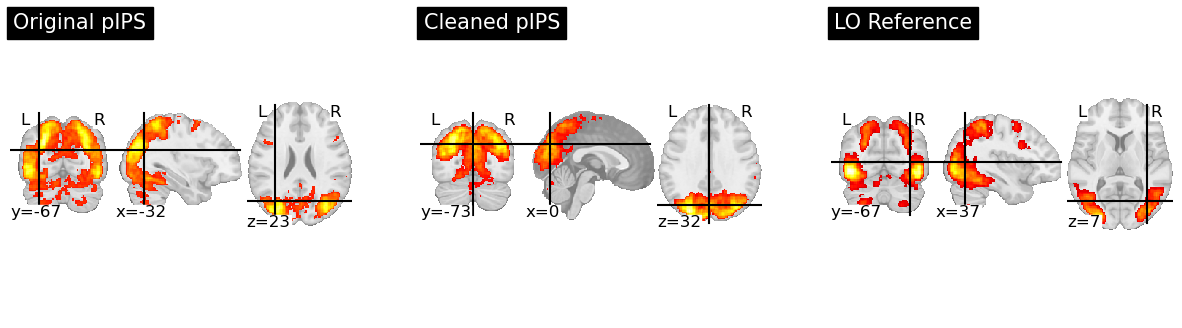

In [39]:
# Check if the spatial patterns look neurobiologically reasonable
from nilearn import plotting

# Quick visualization check
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

plotting.plot_stat_map(pips_orig_left_mean, axes=axes[0], title='Original pIPS', 
                      threshold=0.1, colorbar=False)
plotting.plot_stat_map(pips_clean_left_mean, axes=axes[1], title='Cleaned pIPS', 
                      threshold=0.1, colorbar=False)  
plotting.plot_stat_map(lo_left_mean, axes=axes[2], title='LO Reference', 
                      threshold=0.1, colorbar=False)
plt.show()

# Do the patterns look reasonable? Cleaned should be similar to original but somewhat reduced

In [43]:
# Debug the dice coefficient function
def test_dice_debug():
    # Test with your actual data
    orig_data = pips_orig_left_mean.get_fdata()
    lo_data = lo_left_mean.get_fdata()
    
    print(f"Data shapes: orig={orig_data.shape}, lo={lo_data.shape}")
    
    # Binary threshold
    orig_bin = (orig_data > 0).astype(int)
    lo_bin = (lo_data > 0).astype(int)
    
    intersection = np.sum(orig_bin * lo_bin)
    total = np.sum(orig_bin) + np.sum(lo_bin)
    dice = 2.0 * intersection / total
    
    print(f"Manual calculation: {dice:.4f}")
    
    # Now test your function
    dice_func = compute_dice_coefficient(pips_orig_left_mean, lo_left_mean, threshold=0)
    print(f"Function result: {dice_func:.4f}")
    
    return dice

test_dice_debug()

Data shapes: orig=(91, 109, 91), lo=(91, 109, 91)
Manual calculation: 0.9766
Function result: 0.9766


0.9765670145220784

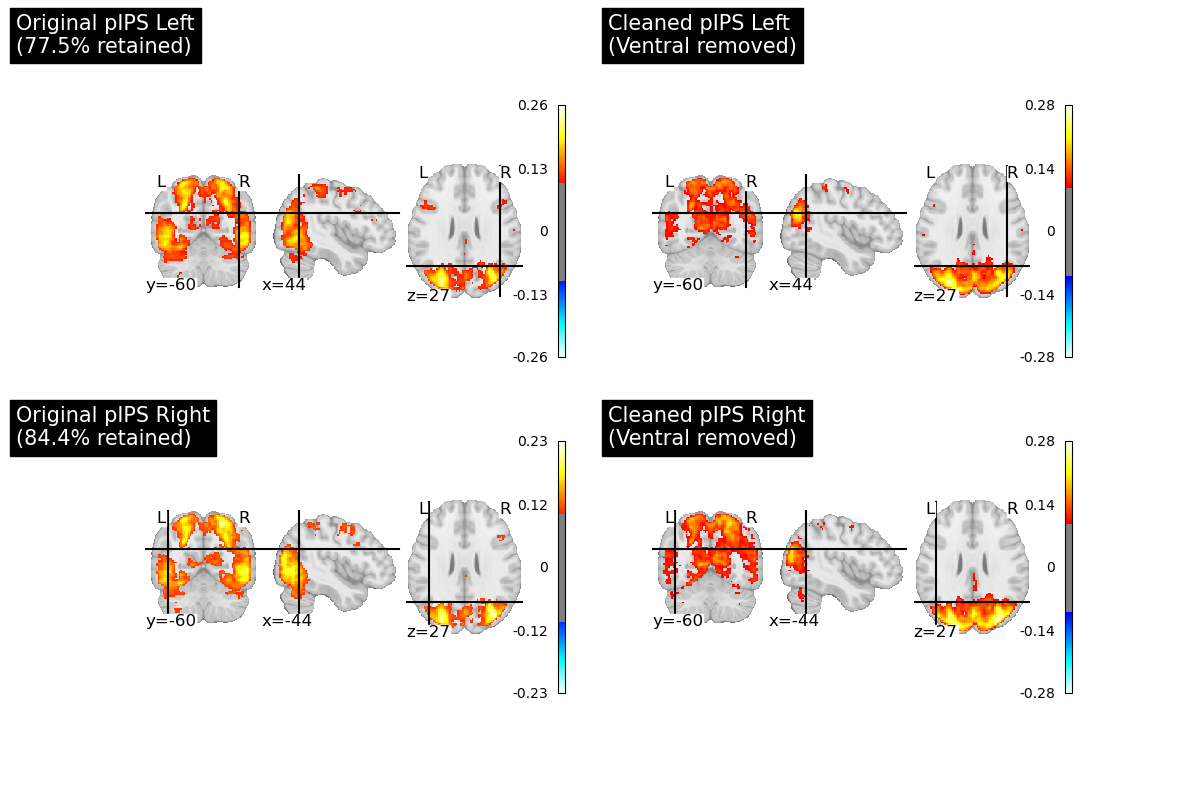

In [50]:
# 2D slice visualization - much clearer
from nilearn import plotting
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Left hemisphere comparison
plotting.plot_stat_map(pips_orig_left_mean, 
                      axes=axes[0,0],
                      title='Original pIPS Left\n(77.5% retained)',
                      threshold=0.1, 
                      colorbar=True,
                      cut_coords=[44, -60, 27])  # pIPS coordinates

plotting.plot_stat_map(pips_clean_left_mean, 
                      axes=axes[0,1],
                      title='Cleaned pIPS Left\n(Ventral removed)',
                      threshold=0.1, 
                      colorbar=True,
                      cut_coords=[44, -60, 27])

# Right hemisphere comparison  
plotting.plot_stat_map(pips_orig_right_mean, 
                      axes=axes[1,0],
                      title='Original pIPS Right\n(84.4% retained)',
                      threshold=0.1, 
                      colorbar=True,
                      cut_coords=[-44, -60, 27])

plotting.plot_stat_map(pips_clean_right_mean, 
                      axes=axes[1,1],
                      title='Cleaned pIPS Right\n(Ventral removed)',
                      threshold=0.1, 
                      colorbar=True,
                      cut_coords=[-44, -60, 27])

plt.tight_layout()
plt.show()

RETENTION ANALYSIS RESULTS:
  hemisphere  n_subjects  orig_threshold  clean_threshold  orig_sig_voxels  \
0       left          18             2.5              2.5            35416   
1      right          18             2.5              2.5            35074   

   clean_sig_voxels  percent_retained  
0             31974              90.3  
1             32192              91.8  


/tmp/ipykernel_1651339/563914557.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


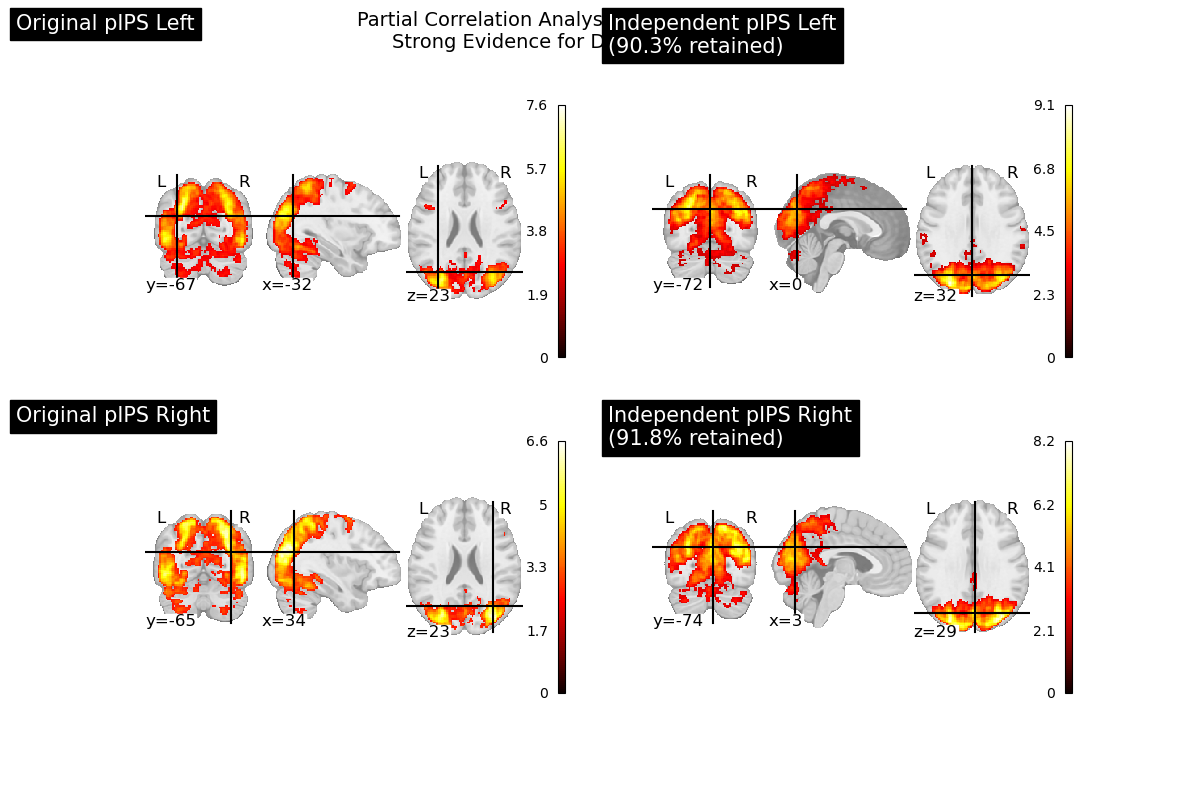


Mean retention: 91.0%
Interpretation: STRONG evidence for dorsal independence


In [1]:
# Simple visualization - copy this into a notebook cell
import os
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
from nilearn import plotting

# Load results
results_dir = "/user_data/csimmon2/git_repos/ptoc/results"
thresh_dir = f"{results_dir}/partial_correlation_thresh"
results_df = pd.read_csv(f'{thresh_dir}/retention_analysis_results.csv')

print("RETENTION ANALYSIS RESULTS:")
print(results_df.round(1))

# Load images and create visualization
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for i, hemi in enumerate(['left', 'right']):
    # Load thresholded images
    orig_img = nib.load(f'{thresh_dir}/pIPS_{hemi}_original_thresh.nii.gz')
    clean_img = nib.load(f'{thresh_dir}/pIPS_{hemi}_cleaned_thresh.nii.gz')
    
    # Get retention value
    retention = results_df[results_df['hemisphere']==hemi]['percent_retained'].iloc[0]
    
    # Plot original
    plotting.plot_stat_map(orig_img, axes=axes[i,0], 
                          title=f'Original pIPS {hemi.title()}',
                          threshold=0.01, colorbar=True)
    
    # Plot cleaned
    plotting.plot_stat_map(clean_img, axes=axes[i,1],
                          title=f'Independent pIPS {hemi.title()}\n({retention:.1f}% retained)',
                          threshold=0.01, colorbar=True)

plt.tight_layout()
plt.suptitle('Partial Correlation Analysis: 91% Mean Retention\nStrong Evidence for Dorsal Independence', 
             y=0.98, fontsize=14)
plt.show()

# Summary statistics
mean_retention = results_df['percent_retained'].mean()
print(f"\nMean retention: {mean_retention:.1f}%")
print("Interpretation: STRONG evidence for dorsal independence")

RETENTION ANALYSIS RESULTS:
  hemisphere  n_subjects  orig_threshold  clean_threshold  orig_sig_voxels  \
0       left          18             2.5              2.5            35416   
1      right          18             2.5              2.5            35074   

   clean_sig_voxels  percent_retained  
0             31974              90.3  
1             32192              91.8  


/tmp/ipykernel_1651339/3706020766.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


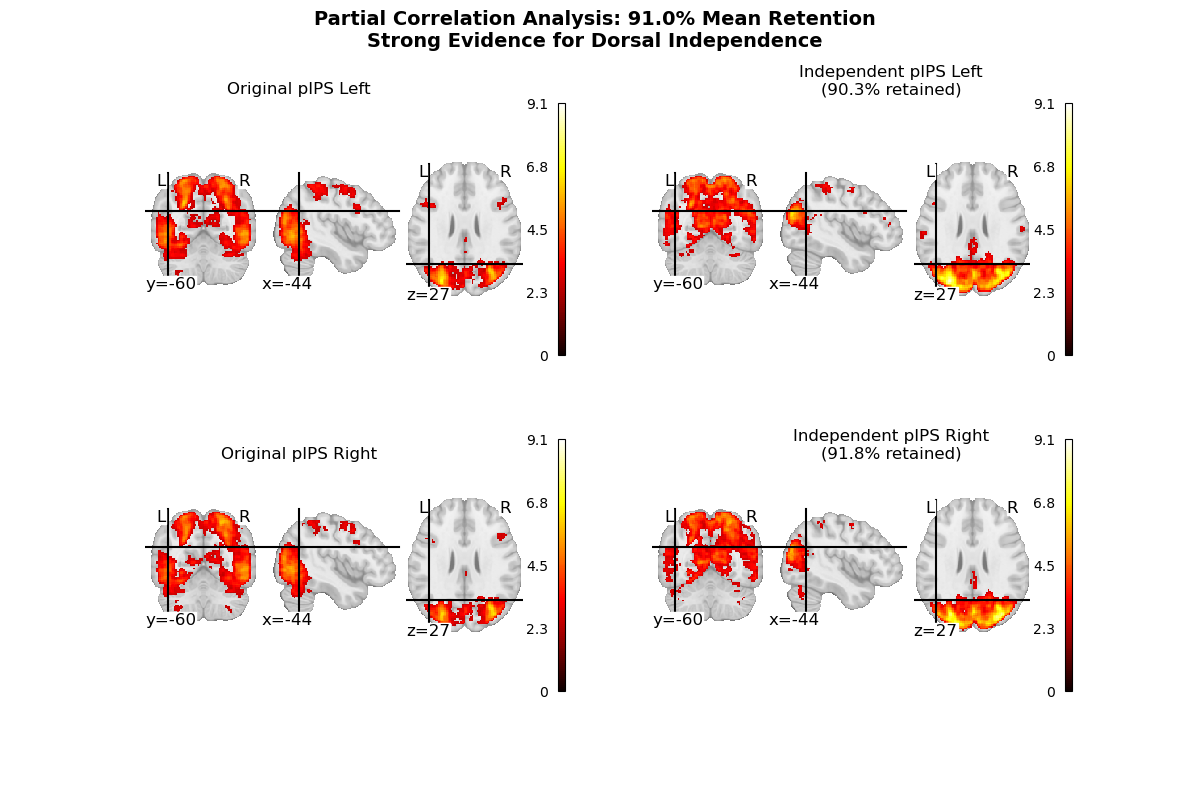


All images now show the same brain coordinates: [-44, -60, 27]
Left: 90.3% retention
Right: 91.8% retention
Mean: 91.0% retention


In [5]:
# Fixed visualization with consistent coordinates
import os
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
from nilearn import plotting
import numpy as np

# Load results
results_dir = "/user_data/csimmon2/git_repos/ptoc/results"
thresh_dir = f"{results_dir}/partial_correlation_thresh"
results_df = pd.read_csv(f'{thresh_dir}/retention_analysis_results.csv')

print("RETENTION ANALYSIS RESULTS:")
print(results_df.round(1))

# Load images
imgs = {}
for hemi in ['left', 'right']:
    imgs[f'orig_{hemi}'] = nib.load(f'{thresh_dir}/pIPS_{hemi}_original_thresh.nii.gz')
    imgs[f'clean_{hemi}'] = nib.load(f'{thresh_dir}/pIPS_{hemi}_cleaned_thresh.nii.gz')

# Calculate global max for consistent scaling
all_data = [img.get_fdata() for img in imgs.values()]
global_max = max([np.max(data[data > 0]) for data in all_data if np.any(data > 0)])

# FIXED: Use same coordinates for all images
cut_coords = [-44, -60, 27]  # pIPS coordinates

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Plot with consistent coordinates
plotting.plot_stat_map(imgs['orig_left'], axes=axes[0,0], 
                      cut_coords=cut_coords, threshold=0.01, vmax=global_max, colorbar=True)
axes[0,0].set_title('Original pIPS Left', fontsize=12)

plotting.plot_stat_map(imgs['clean_left'], axes=axes[0,1], 
                      cut_coords=cut_coords, threshold=0.01, vmax=global_max, colorbar=True)
left_retention = results_df[results_df['hemisphere']=='left']['percent_retained'].iloc[0]
axes[0,1].set_title(f'Independent pIPS Left\n({left_retention:.1f}% retained)', fontsize=12)

plotting.plot_stat_map(imgs['orig_right'], axes=axes[1,0], 
                      cut_coords=cut_coords, threshold=0.01, vmax=global_max, colorbar=True)
axes[1,0].set_title('Original pIPS Right', fontsize=12)

plotting.plot_stat_map(imgs['clean_right'], axes=axes[1,1], 
                      cut_coords=cut_coords, threshold=0.01, vmax=global_max, colorbar=True)
right_retention = results_df[results_df['hemisphere']=='right']['percent_retained'].iloc[0]
axes[1,1].set_title(f'Independent pIPS Right\n({right_retention:.1f}% retained)', fontsize=12)

# Add main title
mean_retention = results_df['percent_retained'].mean()
fig.suptitle(f'Partial Correlation Analysis: {mean_retention:.1f}% Mean Retention\nStrong Evidence for Dorsal Independence', 
             fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(f'{thresh_dir}/final_consistent_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nAll images now show the same brain coordinates: {cut_coords}")
print(f"Left: {left_retention:.1f}% retention")
print(f"Right: {right_retention:.1f}% retention") 
print(f"Mean: {mean_retention:.1f}% retention")

In [24]:
# Check the actual data values before z-scoring
print("Data ranges before z-scoring:")
print(f"Original mean image range: {orig_mean_raw.get_fdata().min():.4f} to {orig_mean_raw.get_fdata().max():.4f}")
print(f"Cleaned mean image range: {clean_mean_raw.get_fdata().min():.4f} to {clean_mean_raw.get_fdata().max():.4f}")

# Check after z-scoring but before thresholding
print("After z-scoring:")
print(f"Original z-scored range: {orig_zstat.get_fdata().min():.4f} to {orig_zstat.get_fdata().max():.4f}")
print(f"Cleaned z-scored range: {clean_zstat.get_fdata().min():.4f} to {clean_zstat.get_fdata().max():.4f}")

Data ranges before z-scoring:


NameError: name 'orig_mean_raw' is not defined

In [10]:
# Verify we're using the correct files
print("Original file path:")
print(f"{study_dir}/sub-XXX/ses-01/derivatives/fc_mni/sub-XXX_pIPS_left_loc_fc_mni.nii.gz")

print("Cleaned file path:")  
print(f"{residual_dir}/sub-XXX/ses-01/derivatives/fc_mni/sub-XXX_pIPS_clean_left_loc_fc_mni.nii.gz")

Original file path:
/lab_data/behrmannlab/vlad/ptoc/sub-XXX/ses-01/derivatives/fc_mni/sub-XXX_pIPS_left_loc_fc_mni.nii.gz
Cleaned file path:
/user_data/csimmon2/ptoc_residuals/sub-XXX/ses-01/derivatives/fc_mni/sub-XXX_pIPS_clean_left_loc_fc_mni.nii.gz
